Saved Pluskal model gain importances to pluskal_model_feature_importance_gain.csv


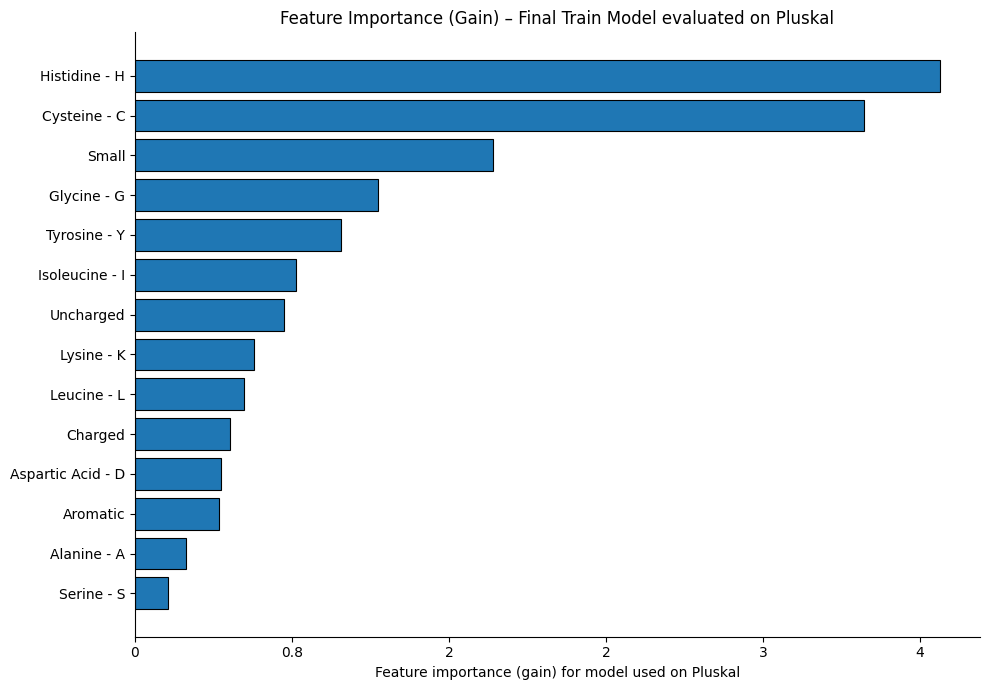


Test Accuracy: 0.8

Confusion Matrix (rows=true, cols=pred):
 [[9 0]
 [3 3]]


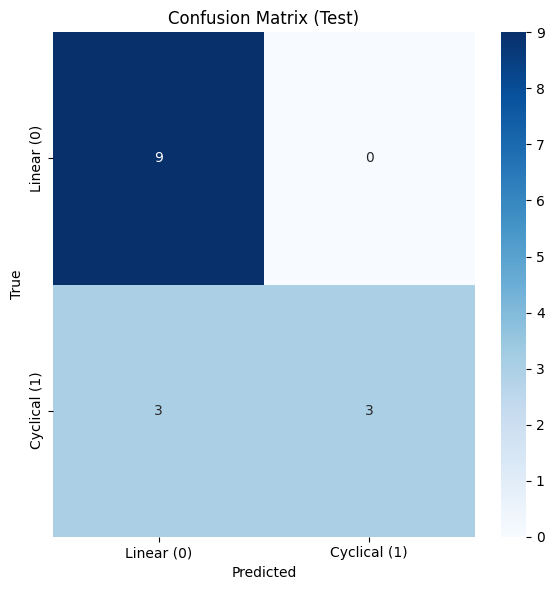


Misclassified test samples:
G8H5M7_M - True: 1, Pred: 0 (Conf: 0.951)
O48935_M - True: 1, Pred: 0 (Conf: 0.523)
Q75WN1_M - True: 1, Pred: 0 (Conf: 0.954)


In [4]:
!pip install --quiet numpy pandas matplotlib xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from matplotlib.ticker import FuncFormatter, MaxNLocator

train_file = "FullDataset.csv"
test_file  = "PreprintExtraLinLimData.csv"
pluskal_importance_png = "pluskal_model_feature_importance_gain.png"
pluskal_importance_csv = "pluskal_model_feature_importance_gain.csv"

selected_features = [
    'Glycine - G','Alanine - A','Leucine - L','Lysine - K','Serine - S',
    'Isoleucine - I','Cysteine - C','Tyrosine - Y','Histidine - H',
    'Aspartic Acid - D','Charged','Uncharged','Small','Aromatic'
]

xgb_params = dict(
    eval_metric="logloss",
    reg_alpha=0.1,
    reg_lambda=1.0,
    verbosity=0,
    random_state=42,
    tree_method="hist",
    device="cuda",
)

fmt = lambda x: f"{x:.3g}"

def one_sf(x, pos):
    if x == 0:
        return "0"
    return f"{float(f'{x:.1g}'):g}"
ONE_SF = FuncFormatter(one_sf)

# Load data
train_df = pd.read_csv(train_file)
test_df  = pd.read_csv(test_file)

# Ensure all required features are available
missing_train = [f for f in selected_features if f not in train_df.columns]
missing_test  = [f for f in selected_features if f not in test_df.columns]
if missing_train:
    raise KeyError(f"Train missing features: {missing_train}")
if missing_test:
    raise KeyError(f"Test missing features: {missing_test}")

X_train = train_df[selected_features].copy()
y_train = train_df["Cyclical"].copy()
X_test  = test_df[selected_features].copy()
y_test  = test_df["Cyclical"].copy()

# Inverse-frequency sample weights
class_weights = y_train.value_counts(normalize=True).to_dict()
weight_map = {k: 1.0 / v for k, v in class_weights.items()}
sample_weights_train_all = y_train.map(weight_map)

# Train model
model = XGBClassifier(**xgb_params)
model.fit(X_train, y_train, sample_weight=sample_weights_train_all, verbose=False)

# Map feature names in gain dictionary
def map_gain_keys(gain_dict, cols):
    if not gain_dict:
        return {}
    if all(k.startswith('f') and k[1:].isdigit() for k in gain_dict.keys()):
        mapped = {}
        for k, v in gain_dict.items():
            idx = int(k[1:])
            mapped[cols[idx]] = mapped.get(cols[idx], 0.0) + v
        return mapped
    return gain_dict

# Feature importance (gain)
final_gain = model.get_booster().get_score(importance_type='gain')
final_gain = map_gain_keys(final_gain, X_train.columns)
final_gain_complete = {f: float(final_gain.get(f, 0.0)) for f in selected_features}

(pd.DataFrame({
    'feature': selected_features,
    'gain': [final_gain_complete[f] for f in selected_features]
}).sort_values('gain', ascending=False)
  .to_csv(pluskal_importance_csv, index=False))
print(f"Saved Pluskal model gain importances to {pluskal_importance_csv}")

# Plot feature importance
order_final = sorted(selected_features, key=lambda f: final_gain_complete[f], reverse=True)
vals_final  = [final_gain_complete[f] for f in order_final]

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(order_final, vals_final, edgecolor='black', linewidth=0.8)
ax.set_xlabel('Feature importance (gain) for model used on Pluskal')
ax.set_title('Feature Importance (Gain) – Final Train Model evaluated on Pluskal')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(ONE_SF)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
for spine in ("top","right"):
    ax.spines[spine].set_visible(False)
fig.tight_layout()
fig.savefig(pluskal_importance_png, dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Evaluate on Pluskal test set
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {fmt(acc)}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)

labels = ["Linear (0)", "Cyclical (1)"]
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

# Misclassified proteins
ids = test_df["Protein"].values
mis = []
for i, (t, p) in enumerate(zip(y_test, y_pred)):
    if t != p:
        mis.append((ids[i], int(t), int(p), float(np.max(y_proba[i]))))

if mis:
    print("\nMisclassified test samples:")
    for obs, true, pred, conf in mis:
        print(f"{obs} - True: {true}, Pred: {pred} (Conf: {fmt(conf)})")
else:
    print("\nNo misclassified test samples.")